In [ ]:
import multiprocessing as mp

# Check if the start method is already set
try:
    mp.set_start_method('spawn')
except RuntimeError as e:
    print("Start method has already been set. Current method:",
          mp.get_start_method())


Start method has already been set. Current method: spawn


In [ ]:
# @title Package Installation
!pip install --upgrade google-auth google-auth-oauthlib google-api-python-client

In [ ]:
# @title Imports
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import random

%load_ext tensorboard

In [ ]:
# @title Dataset Acquisition

# Downloads the dataset to a temp variable for use during runtime.
def create_service():
    from google.colab import auth
    auth.authenticate_user()
    from google.auth import default
    creds, _ = default()
    return build('drive', 'v3', credentials=creds)

def download_file(file_id, file_name):
    service = create_service()
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    with io.open(file_name, 'wb') as f:
        fh.seek(0)
        f.write(fh.read())


download_file('12iYYEF81xzxtKe0LmxoLc3Q4UD-aGveG', 'Places2_simp.zip')
download_file("10bG9go_5zoHnxh92T7HRRHGmgdPmOKC7", "testset.zip")
#-------------------------------------------------------------------------------
!unzip -o Places2_simp.zip

!unzip -o testset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Places2_simp/phone_booth/00000377.jpg  
  inflating: Places2_simp/phone_booth/00000439.jpg  
  inflating: Places2_simp/phone_booth/00000388.jpg  
  inflating: Places2_simp/phone_booth/00000607.jpg  
  inflating: Places2_simp/phone_booth/00000161.jpg  
  inflating: Places2_simp/phone_booth/00000175.jpg  
  inflating: Places2_simp/phone_booth/00000613.jpg  
  inflating: Places2_simp/phone_booth/00000149.jpg  
  inflating: Places2_simp/phone_booth/00000808.jpg  
  inflating: Places2_simp/phone_booth/00000820.jpg  
  inflating: Places2_simp/phone_booth/00000834.jpg  
  inflating: Places2_simp/phone_booth/00000773.jpg  
  inflating: Places2_simp/phone_booth/00000015.jpg  
  inflating: Places2_simp/phone_booth/00000001.jpg  
  inflating: Places2_simp/phone_booth/00000767.jpg  
  inflating: Places2_simp/phone_booth/00000997.jpg  
  inflating: Places2_simp/phone_booth/00000029.jpg  
  inflating: Places2_simp/phone_booth/00000983.j

In [ ]:
# @title Hyperparameter Definitions

# Model config
# True = resnet50, False = resnet34
USE_RESNET50 = True


# Hyperparameters
NUM_EPOCHS = 50
PATIENCE = 15
WEIGHT_DECAY = 0.0008
DROPOUT_RATE = 0.5


# Dataset parameters
TRAIN_BATCH_SIZE = 256
VALIDATION_BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.2


# Learning rates per layer config
USE_PER_LAYER_LR = True
FT_LEARNING_RATE = 0.0001
CL_LEARNING_RATE = 0.001
STEP_SIZE = 6


# Data transformation/augmentation
DATA_AUG_RESIZE = (244, 244)
DATA_AUG_ROTATE = (-20, 20)
DATA_AUG_SCALING = (0.5, 2.0)
DATA_AUG_TRANSLATE = (0.2, 0.2)

In [ ]:
# @title Data Augmentation

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize(DATA_AUG_RESIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=DATA_AUG_ROTATE),
    transforms.RandomAffine(degrees=0, translate=DATA_AUG_TRANSLATE,
                            scale=DATA_AUG_SCALING),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Normalisation and resizing for test dataset, we dont apply transforms to the
# test dataset.
test_transform = transforms.Compose([
    transforms.Resize(DATA_AUG_RESIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# @title Dataset Loader

# Load the datasets
dataset_path = '/content/Places2_simp'
test_dataset_path = '/content/testset'
# Assumes subdirectories in 'train' are class names
class_names = os.listdir(dataset_path)
class_names.sort()

if not os.path.exists(dataset_path):
    print("Dataset path is invalid")
else:
    print("Dataset path is valid")
    if not os.listdir(dataset_path):
        print("Dataset directory is empty")
    else:
        full_dataset = datasets.ImageFolder(root=dataset_path,
                                            transform=transform)
        print("Dataset loaded successfully")
test_dataset = datasets.ImageFolder(root=test_dataset_path,
                                    transform=test_transform)

# Shuffle the dataset
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

# Split dataset into training and validation sets
split = int(np.floor(VALIDATION_SPLIT * len(indices)))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Define loaders for train, validation and test.
train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          sampler=train_sampler, num_workers=2)
val_loader = DataLoader(full_dataset, batch_size=VALIDATION_BATCH_SIZE,
                        sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE,
                         shuffle=False, num_workers=2)
images, labels = next(iter(train_loader))


Dataset path is valid
Dataset loaded successfully


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e810b5dbe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _er

In [ ]:
# @title Model Definition

# Define a custom resnet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes, use_resnet50):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet-34/50 model

        if use_resnet50:
            resnet = models.resnet50(weights='IMAGENET1K_V1')
        else:
            resnet = models.resnet34(weights='IMAGENET1K_V1')


        # Use all layers except the original fully connected layer
        self.features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool,
        )

        # Get the number of input features to the last layer
        num_features = resnet.fc.in_features

        # Create new classifier layers and dropout
        self.classifier = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(num_features, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# @title Model Instantiation

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet(num_classes=40, use_resnet50 = USE_RESNET50).to(device)

In [ ]:
# @title Optimiser and Scheduler Setup

# Optimizer and loss function

# Group parameters by layer with different learning rates
if USE_PER_LAYER_LR:
    param_groups = [
        {'params': model.features.parameters(), 'lr': FT_LEARNING_RATE},
        {'params': model.classifier.parameters(), 'lr': CL_LEARNING_RATE}
    ]
    optimizer = optim.Adam(param_groups, weight_decay=WEIGHT_DECAY)
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=0.06)

# If not configured to use mutli-layer learning rates, it runs standard config.
else:
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                           lr=CL_LEARNING_RATE, weight_decay=WEIGHT_DECAY)


criterion = nn.CrossEntropyLoss()

In [ ]:
# @title Visualize Feature Maps

# Visualisation for feature maps on each layer.
def visualize_feature_maps(model, input_image, selected_layer_index):
    model.eval()
    activation = {}

    def get_activation():
        def hook(model, input, output):
            # Ensure the output is moved to CPU
            activation['output'] = output.detach().cpu()
        return hook

    # Access the selected layer by index directly from the
    #'features' module if it's a sequential model
    layer = model.features[selected_layer_index]

    # Register hook using a direct callable without accessing 'name'
    hook = layer.register_forward_hook(get_activation())

    # Execute model forward pass
    with torch.no_grad():
        # Ensure the input image is on the same device as the model
        output = model(input_image.to(device))

    # Remove the hook after use to clean up
    hook.remove()

    # Get feature maps from the stored activations and display 5 of them
    feature_maps = activation['output'].squeeze()
    num_feature_maps = min(feature_maps.size(0), 5)

    # Set figure size
    fig, axarr = plt.subplots(nrows=num_feature_maps,
                              figsize=(5, num_feature_maps * 3))

    for idx in range(num_feature_maps):
        # Handle single subplot scenario
        ax = axarr[idx] if num_feature_maps > 1 else axarr

        ax.imshow(feature_maps[idx], cmap='magma')
        ax.axis('off')

    plt.tight_layout()
    plt.show()




In [ ]:
# @title Compute mAP and Confusion Matrix


def compute_map(true_labels, predicted_scores, num_classes):
    true_binary = label_binarize(true_labels, classes=range(num_classes))
    mAP = average_precision_score(true_binary,
                                  predicted_scores, average="macro")
    return mAP

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(20, 15))

    # Create the heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 6})

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.show()

# Function to display top predictions along with the image
def display_top_predictions(model, device, loader, class_names, num_images=5):
    model.eval()
    inputs, labels = next(iter(loader))
    outputs = model(inputs.to(device))
    _, predictions = outputs.topk(5, dim=1, largest=True, sorted=True)

    # Define the mean and std used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(inputs))):
        img = inputs[i].cpu().numpy().transpose((1, 2, 0))
        # Normalize
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title("\n".join([f"{class_names[predictions[i][j]]}: {outputs[i][predictions[i][j]].item():.2f}" for j in range(5)]))
        plt.axis("off")
    plt.show()

In [ ]:
# @title Random Validation Image Representation

def display_images(images, labels, predictions, scores, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(nrows=1, ncols=num_images,
                            figsize=(num_images * 5, 10))
    if num_images == 1:
        axs = [axs]

    for i, (img, label, pred, score) in enumerate(zip(images, labels,
                                                      predictions, scores)):
        ax = axs[i]
        img_display = img.cpu().permute(1, 2, 0)
        ax.imshow(img_display)
        title = f"Actual: {class_names[label]} - Top Predictions:\n"
        for j in range(5):
            title += f"{class_names[pred[j]]}: {score[j]:.2f}%\n"
        ax.set_title(title, fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# @title Mean Average Precision

def compute_map(true_labels, predicted_scores, num_classes):
    true_binary = label_binarize(true_labels, classes=range(num_classes))
    mAP = average_precision_score(true_binary,
                                  predicted_scores, average="macro")
    return mAP

In [ ]:
# @title Training Loop

# Training and validation functions
def train_epoch(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if USE_PER_LAYER_LR:
        scheduler.step()
    return running_loss / len(train_loader)



In [ ]:
# @title Validation loop

# Validation loop with modifications to display images
def validate(model, device, val_loader, criterion, class_names, num_samples=5):
    model.eval()
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    all_labels = []
    all_predictions = []
    # Store the predicted probabilities for mAP calculation
    all_scores = []
    sample_images = []
    sample_labels = []
    sample_predictions = []
    sample_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted_top1 = torch.max(outputs, 1)
            correct_top1 += (predicted_top1 == labels).sum().item()

            _, predicted_top5 = torch.topk(outputs, 5, dim=1,
                                           largest=True, sorted=True)
            correct_top5 += (predicted_top5 == labels.view(-1, 1)).sum().item()

            all_labels.append(labels.cpu())
            all_predictions.append(predicted_top1.cpu())
            all_scores.append(torch.softmax(outputs, dim=1).cpu().numpy())

            total += labels.size(0)

            # Collect samples for display
            if len(sample_images) < num_samples:
                # Randomly pick an index to sample
                idx = random.randint(0, labels.size(0) - 1)
                sample_images.append(inputs[idx])
                sample_labels.append(labels[idx].item())
                sample_predictions.append(predicted_top5[idx].cpu().numpy())
                sample_scores.append(torch.softmax(
                    outputs, dim=1)[idx].cpu().numpy() * 100)
    all_scores = np.concatenate(all_scores, axis=0)
    all_labels_cat = torch.cat(all_labels).numpy()
    all_predictions_cat = torch.cat(all_predictions).numpy()

    f1 = f1_score(all_labels_cat, all_predictions_cat, average='weighted')
    num_classes = model.classifier[-1].out_features
    true_binary = label_binarize(all_labels_cat, classes=range(num_classes))
    mAP = average_precision_score(true_binary, all_scores, average="macro")

    accuracy_top1 = 100 * correct_top1 / total
    accuracy_top5 = 100 * correct_top5 / total
    average_loss = running_loss / len(val_loader)

    display_images(sample_images, sample_labels,
                   sample_predictions, sample_scores, class_names)

    return {
        "loss": average_loss,
        "accuracy_top1": accuracy_top1,
        "accuracy_top5": accuracy_top5,
        "f1_score": f1,
        "mAP": mAP,
        "true_labels": all_labels_cat,
        "predicted_labels": all_predictions_cat
    }


Epoch 1/50:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

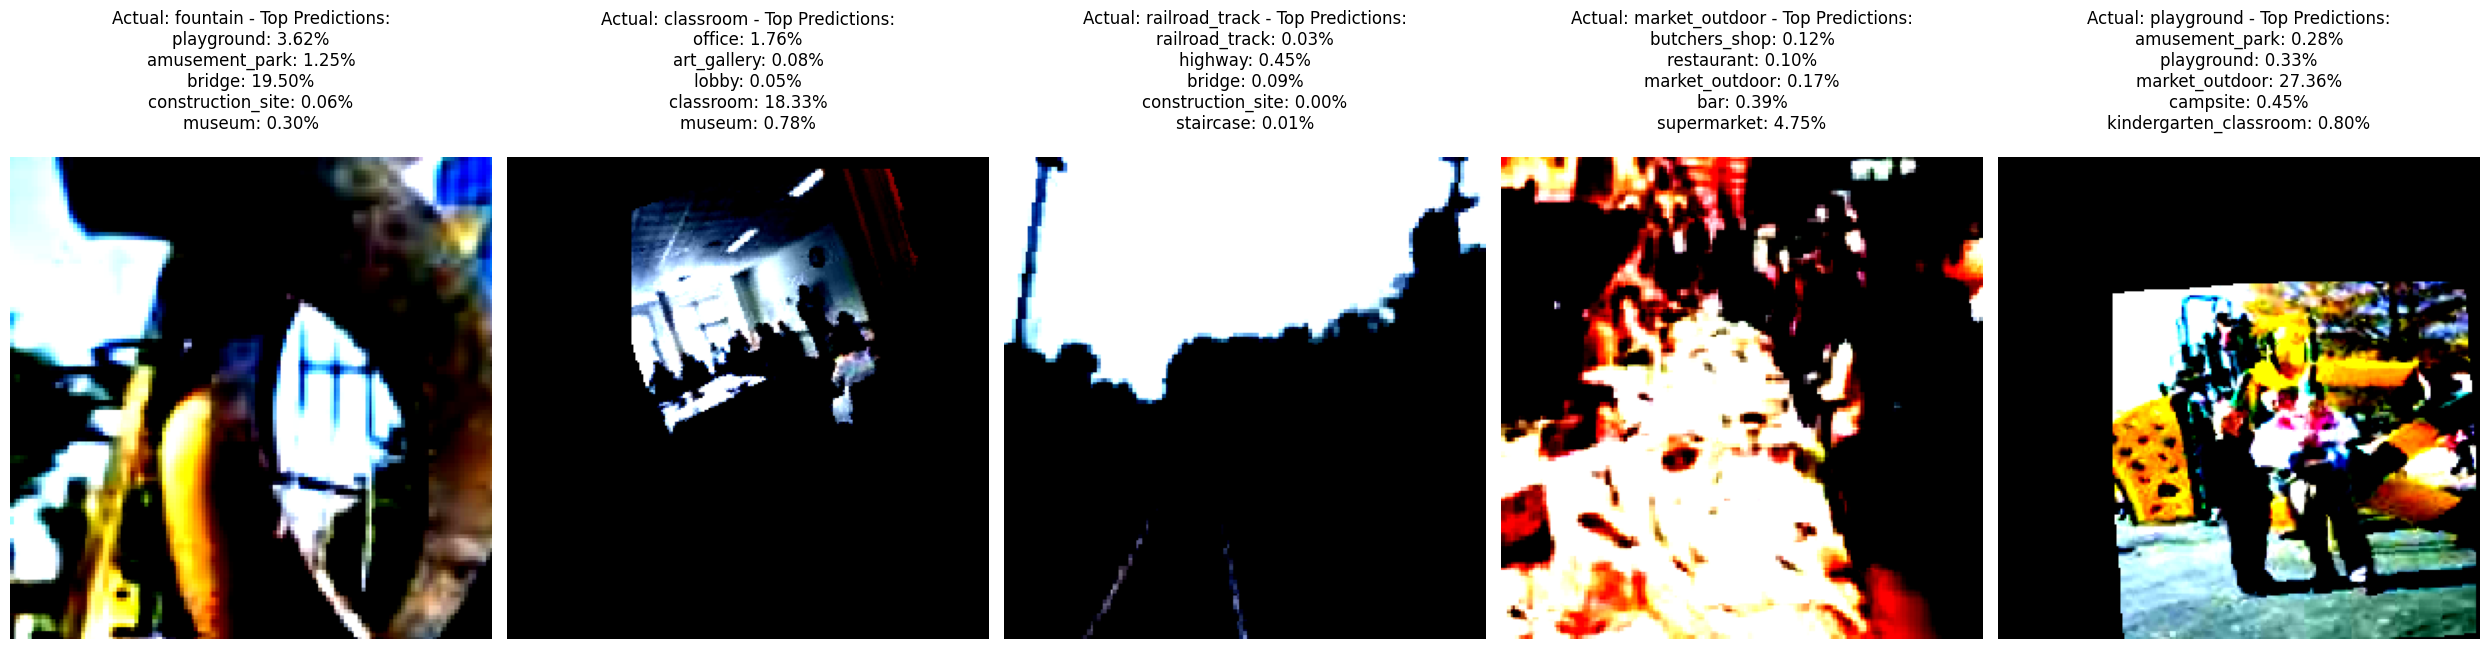

Visualizing Feature Maps after Epoch 1
Visual features after 1st layer : 




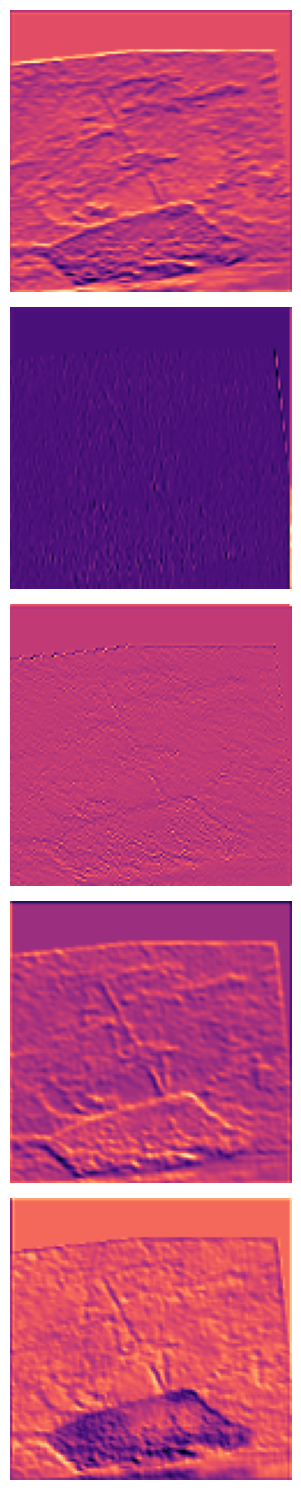

Visual features after 3rd layer :




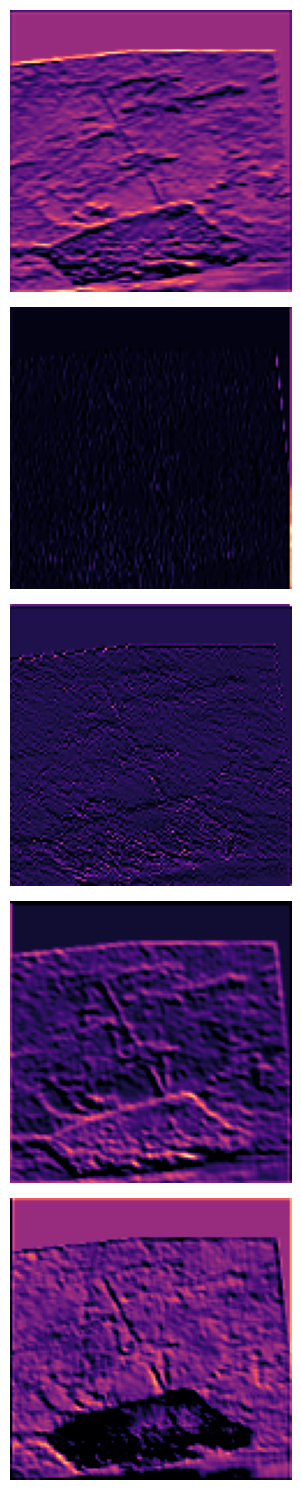

Visual features after 4th layer :




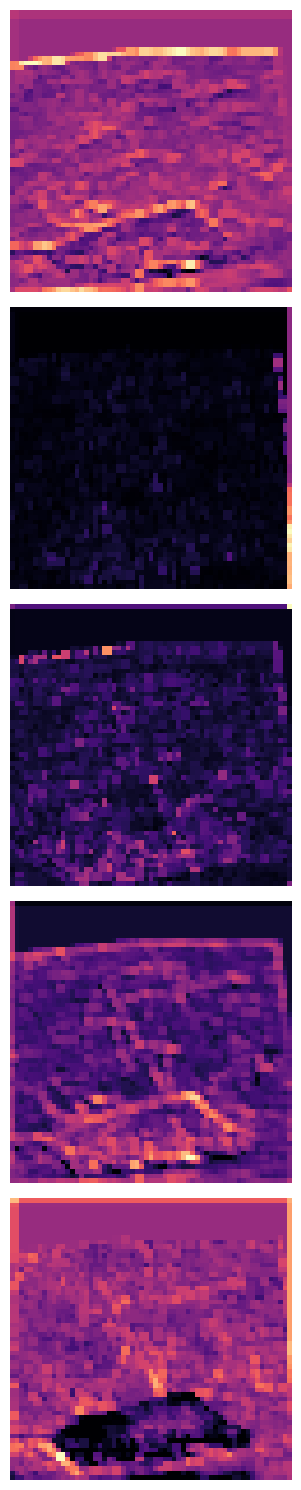

Visual features after 5th layer :




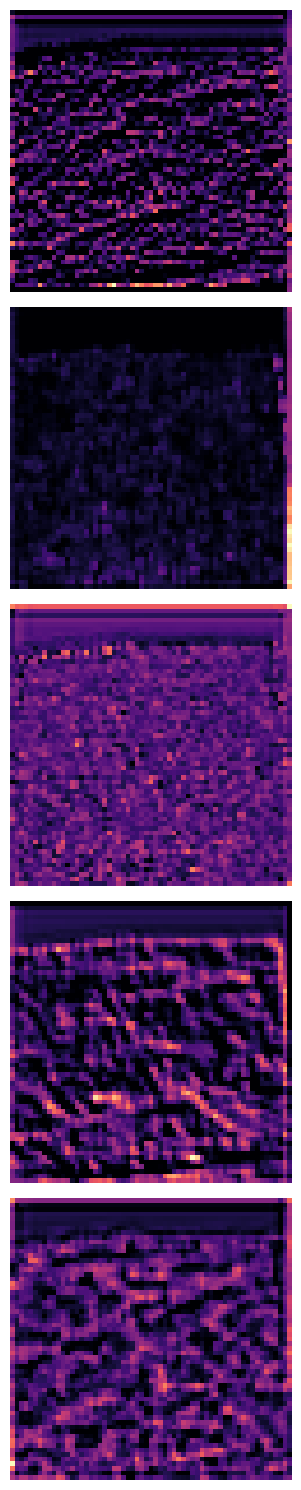

Visual features after 7th layer :




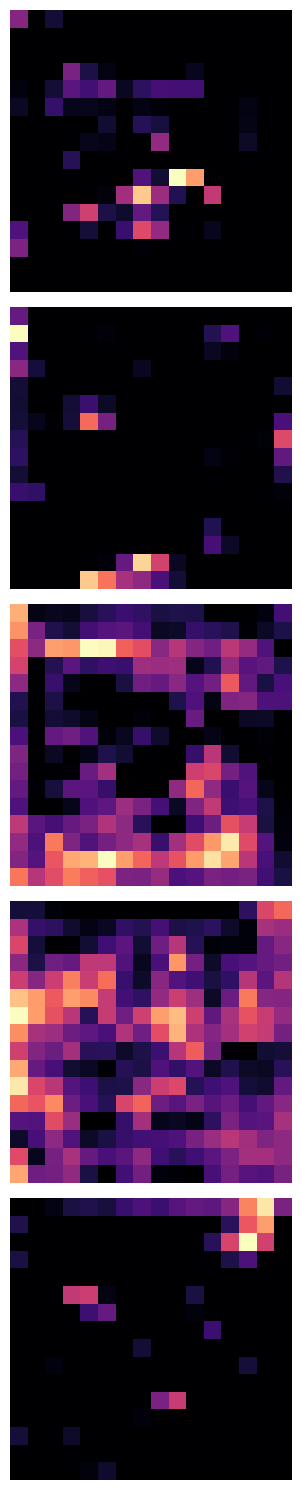

Visual features after final layer :




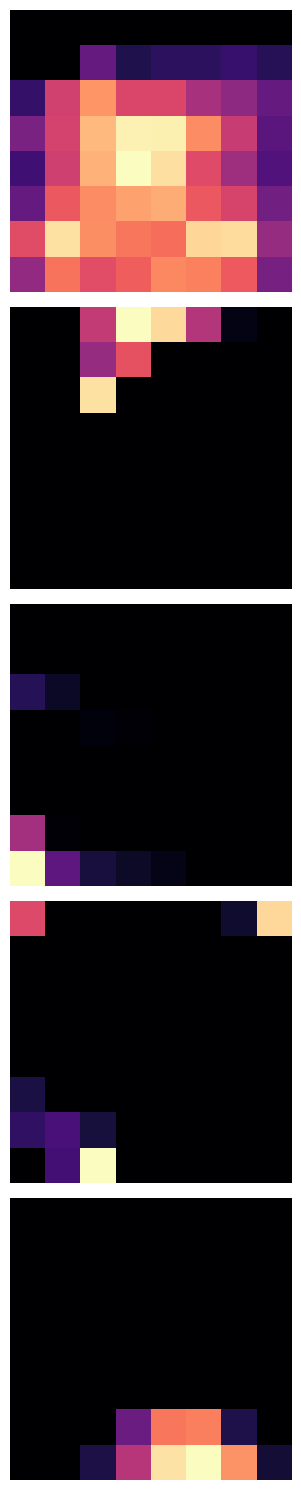

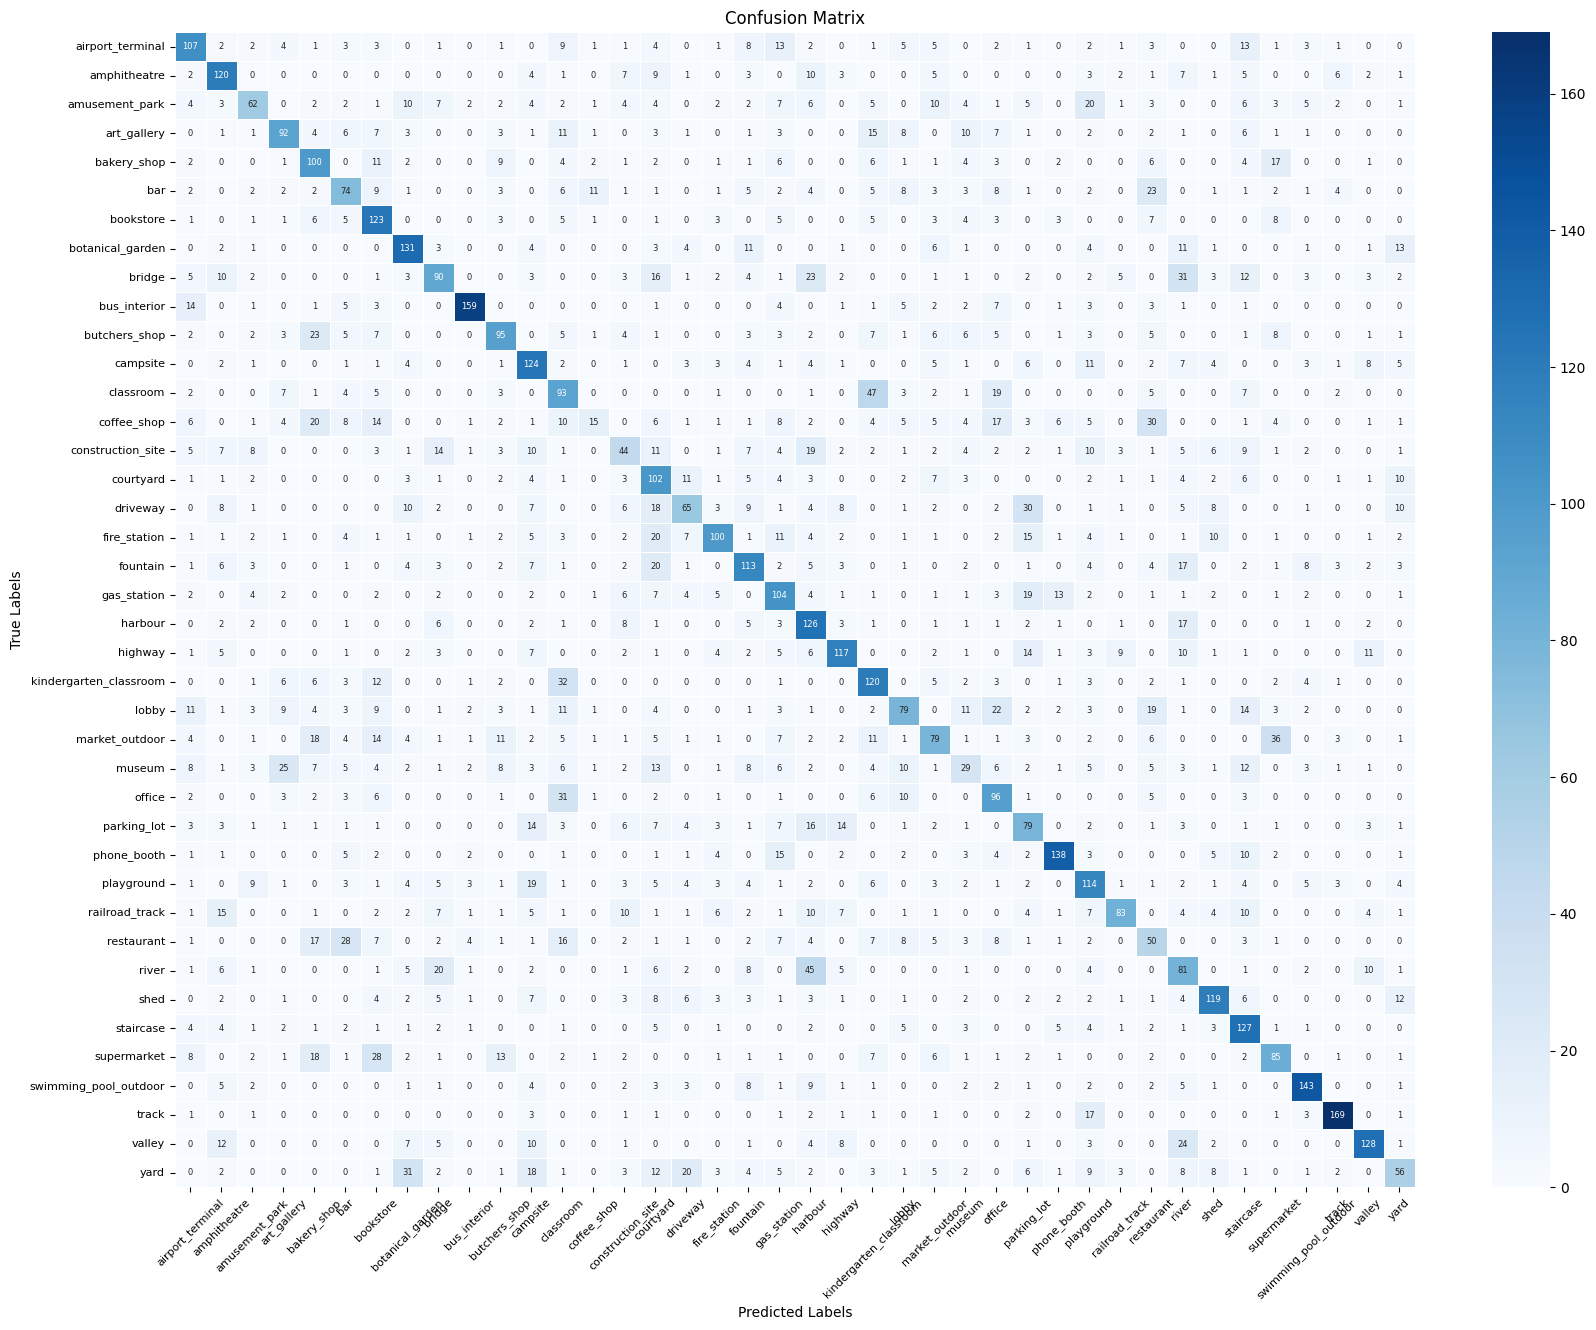

Model improved and saved with accuracy: 49.14%
Epoch 2/50:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

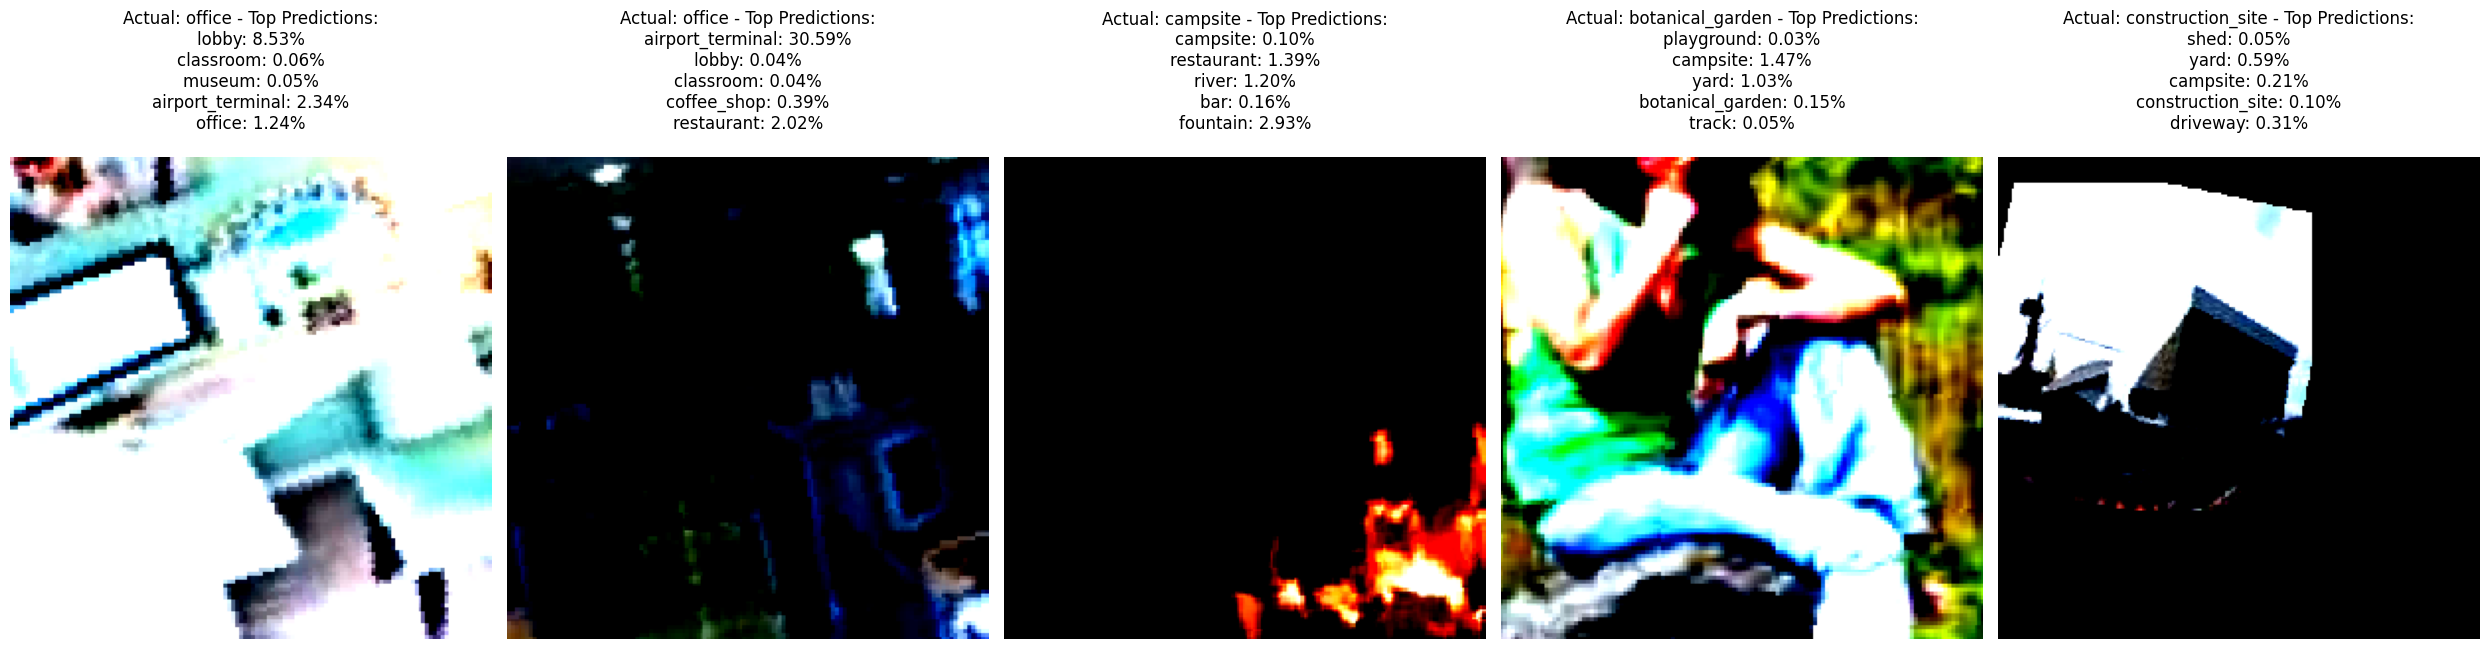

Visualizing Feature Maps after Epoch 2
Visual features after 1st layer : 




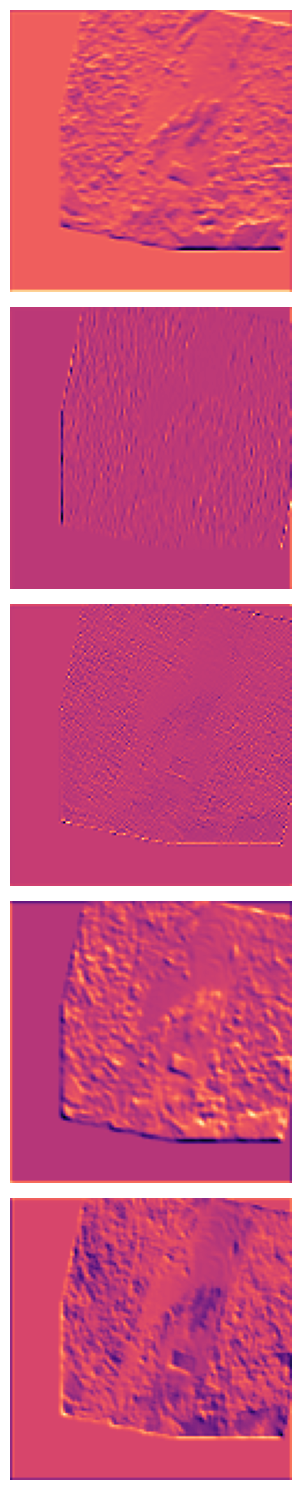

Visual features after 3rd layer :




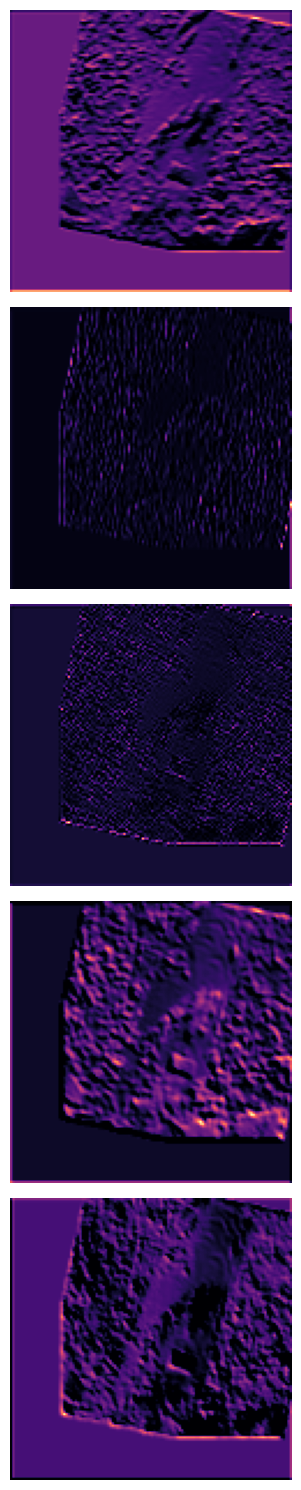

Visual features after 4th layer :




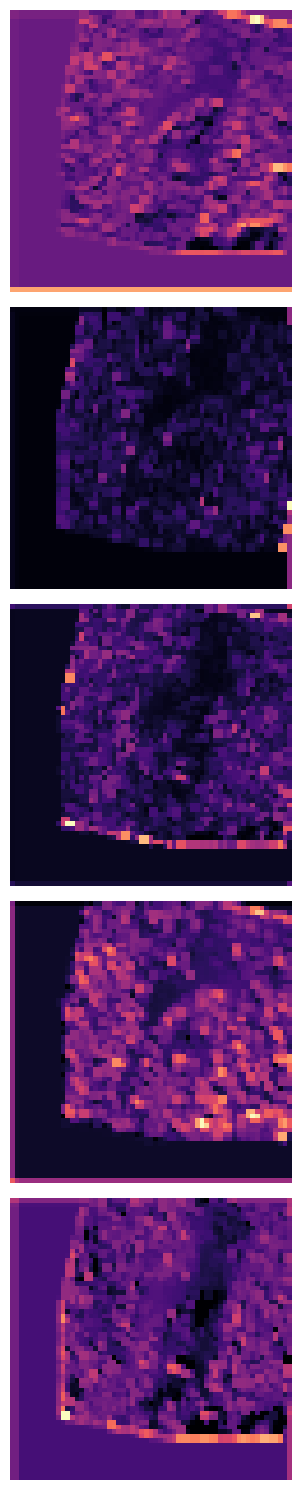

Visual features after 5th layer :




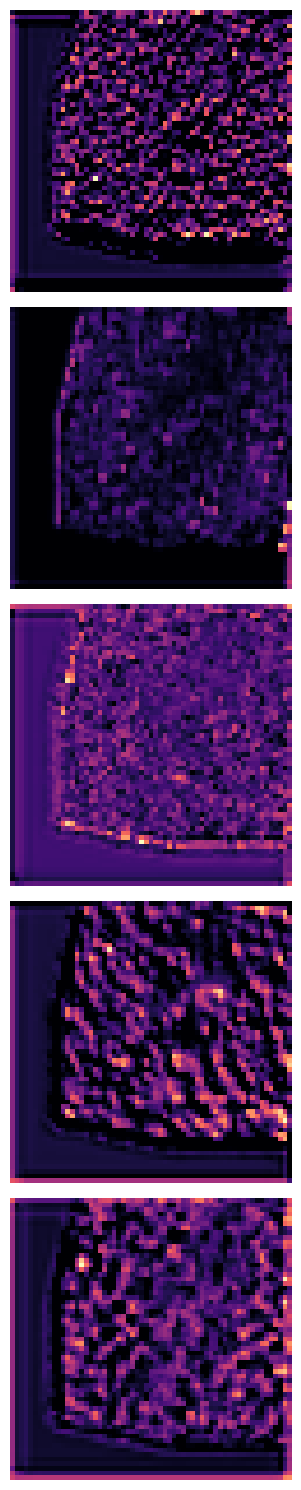

Visual features after 7th layer :




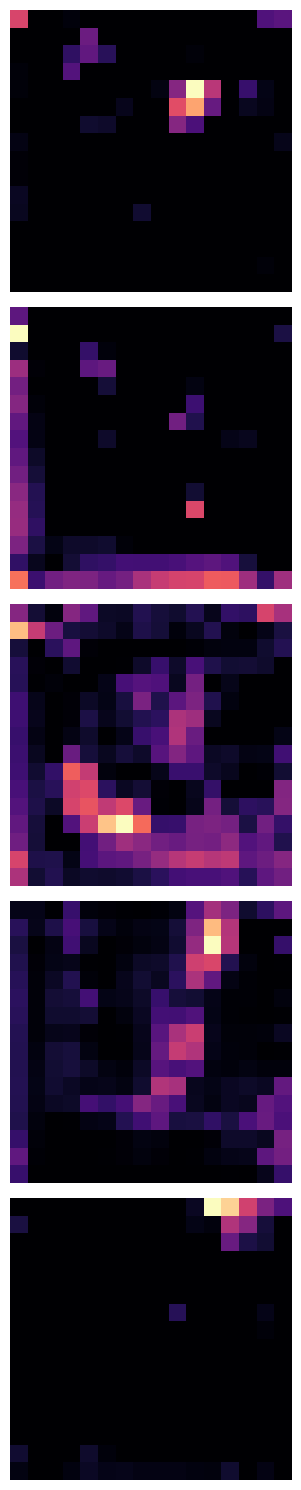

Visual features after final layer :




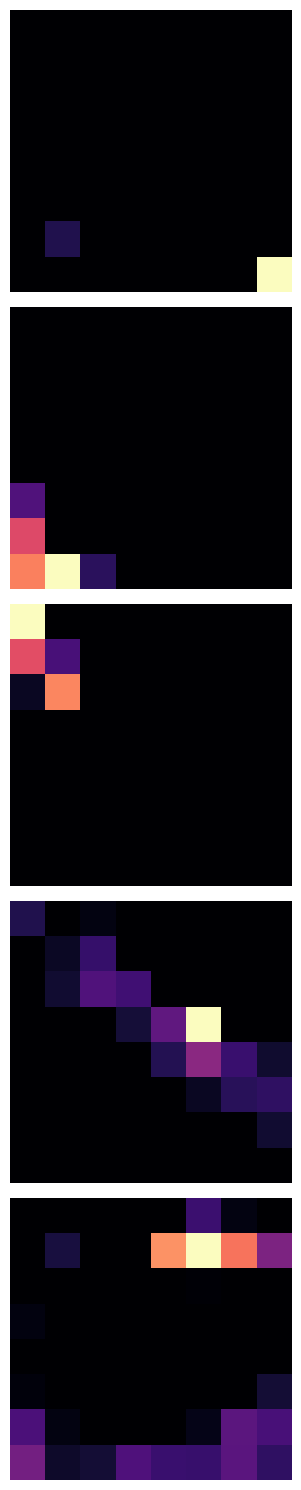

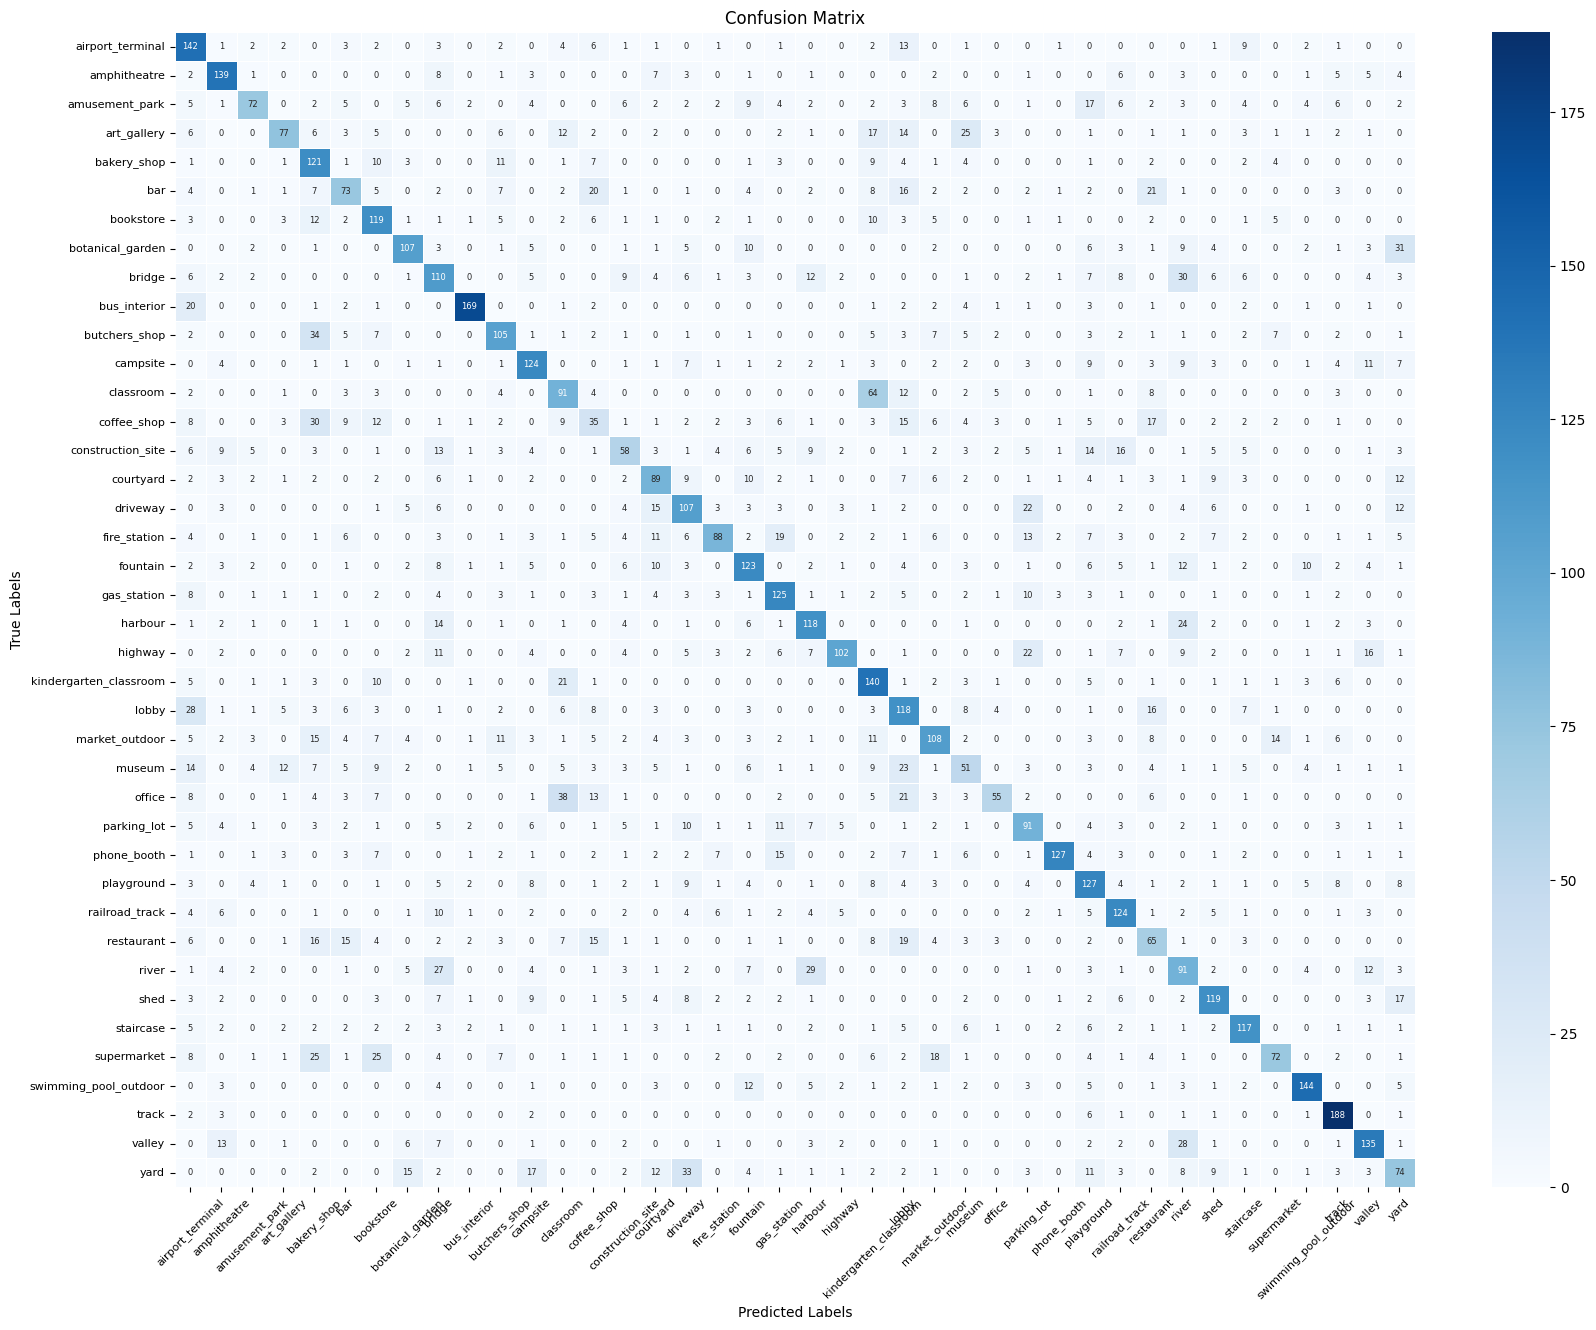

Model improved and saved with accuracy: 53.00%
Epoch 3/50:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

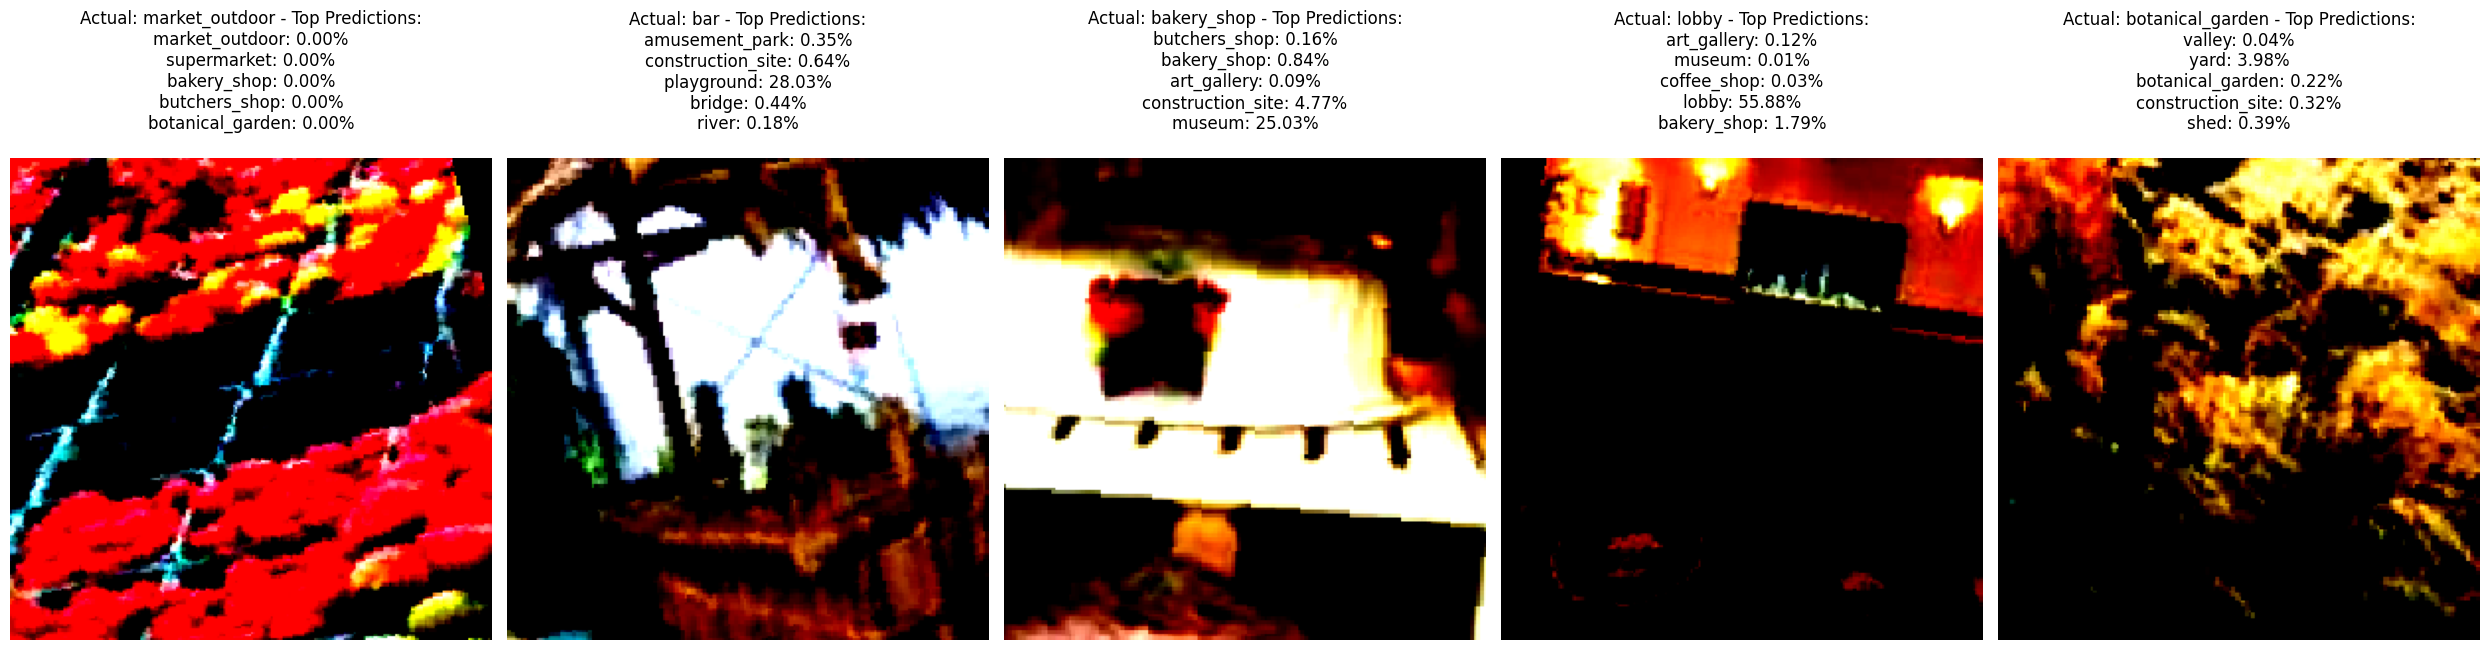

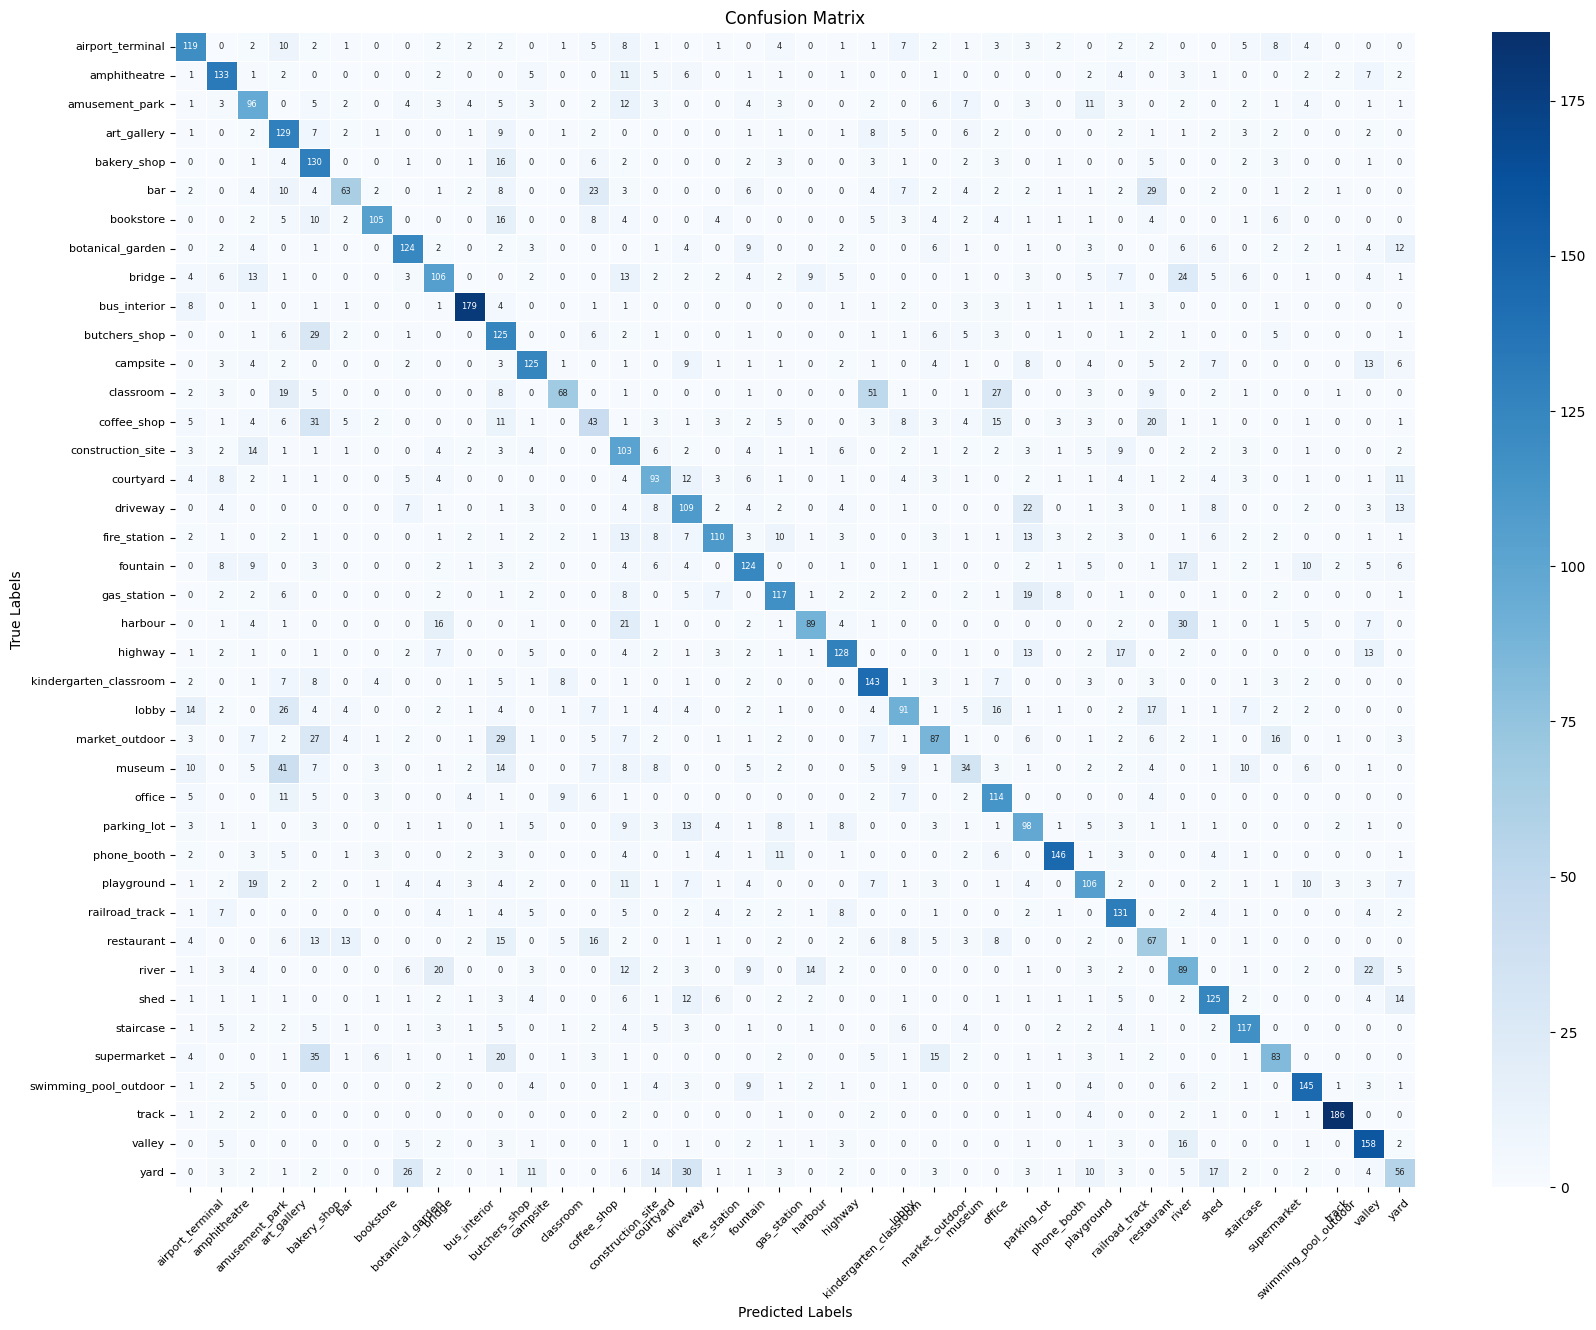

Model improved and saved with accuracy: 54.92%
Epoch 4/50:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

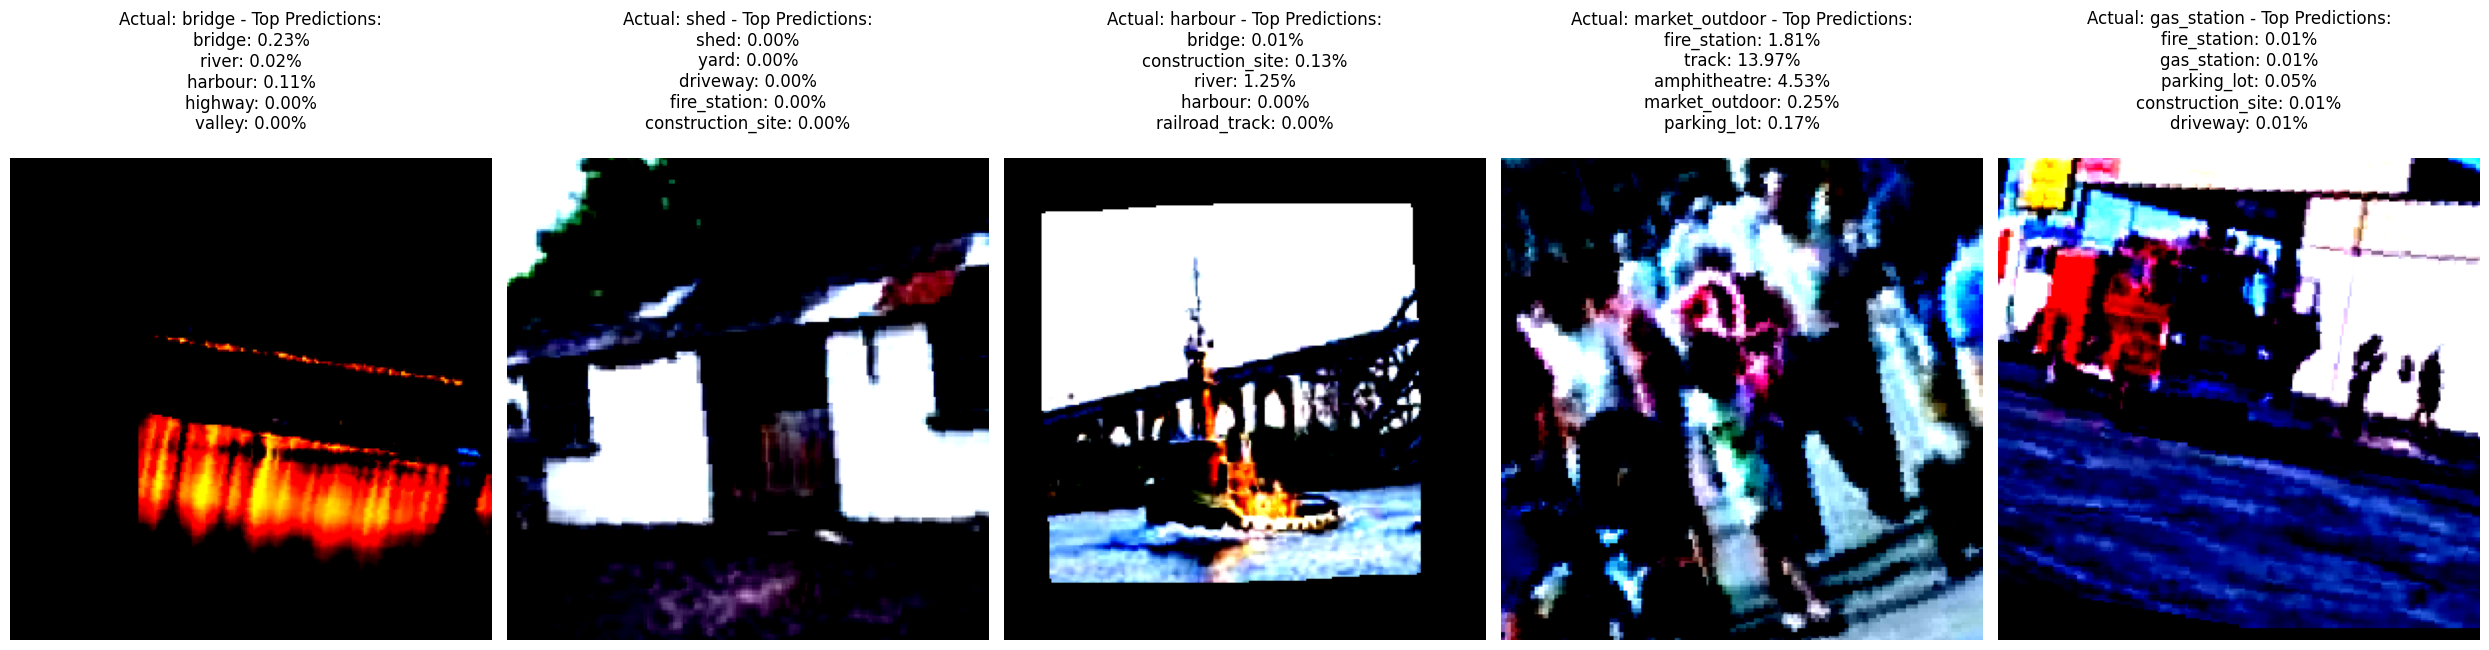

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e810b5dbe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _er

Visualizing Feature Maps after Epoch 4
Visual features after 1st layer : 




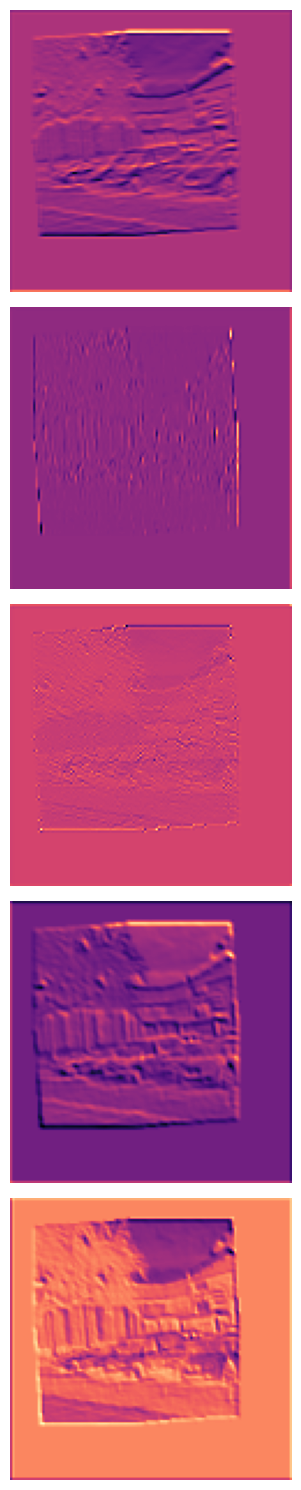

Visual features after 3rd layer :




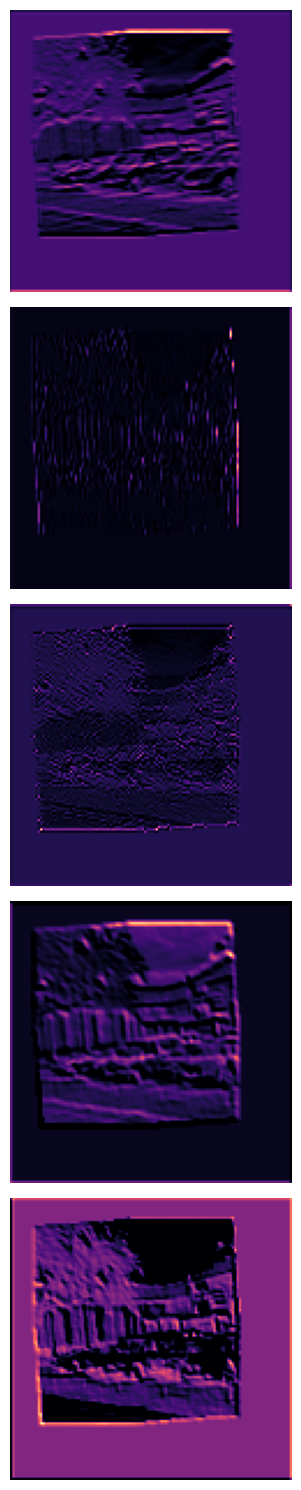

Visual features after 4th layer :




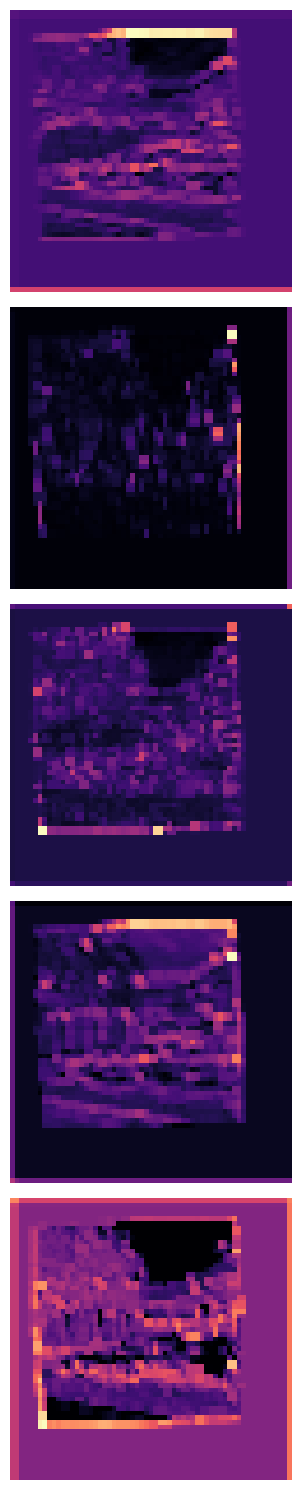

Visual features after 5th layer :




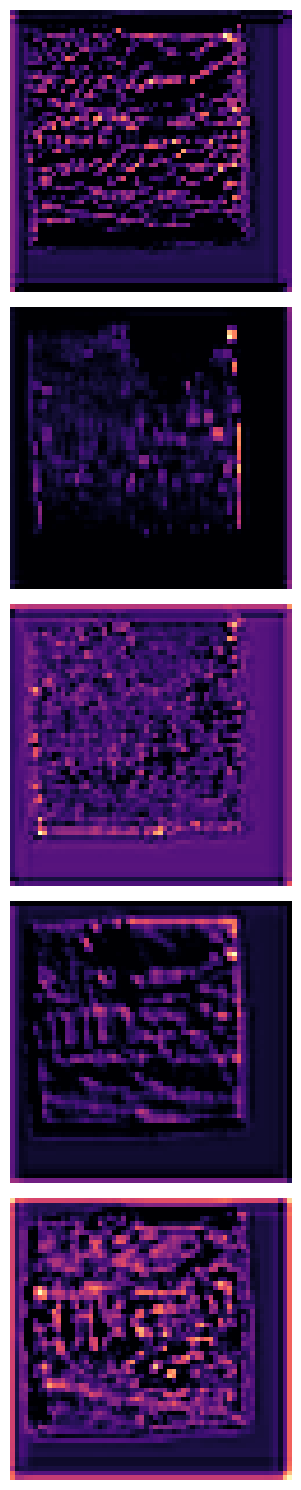

Visual features after 7th layer :




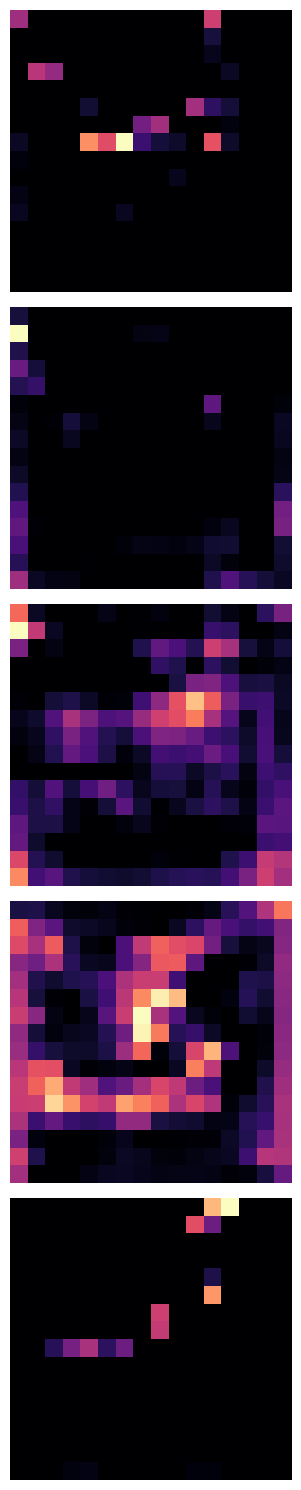

Visual features after final layer :




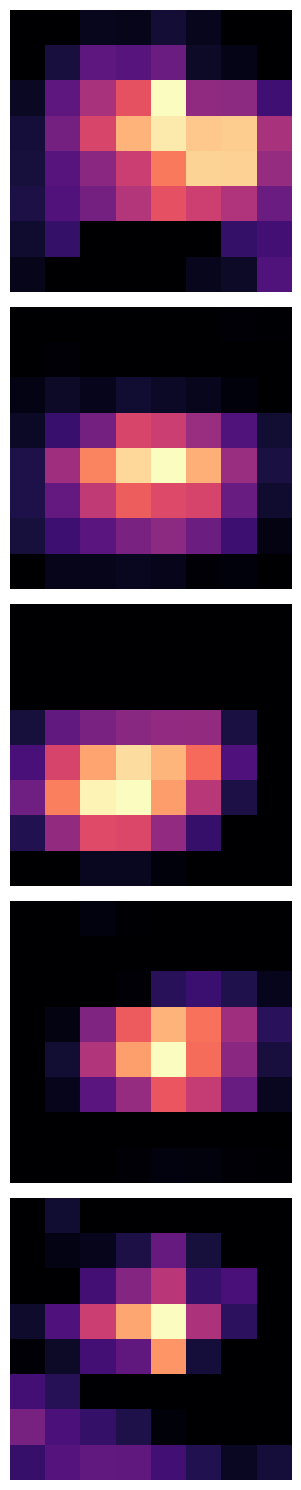

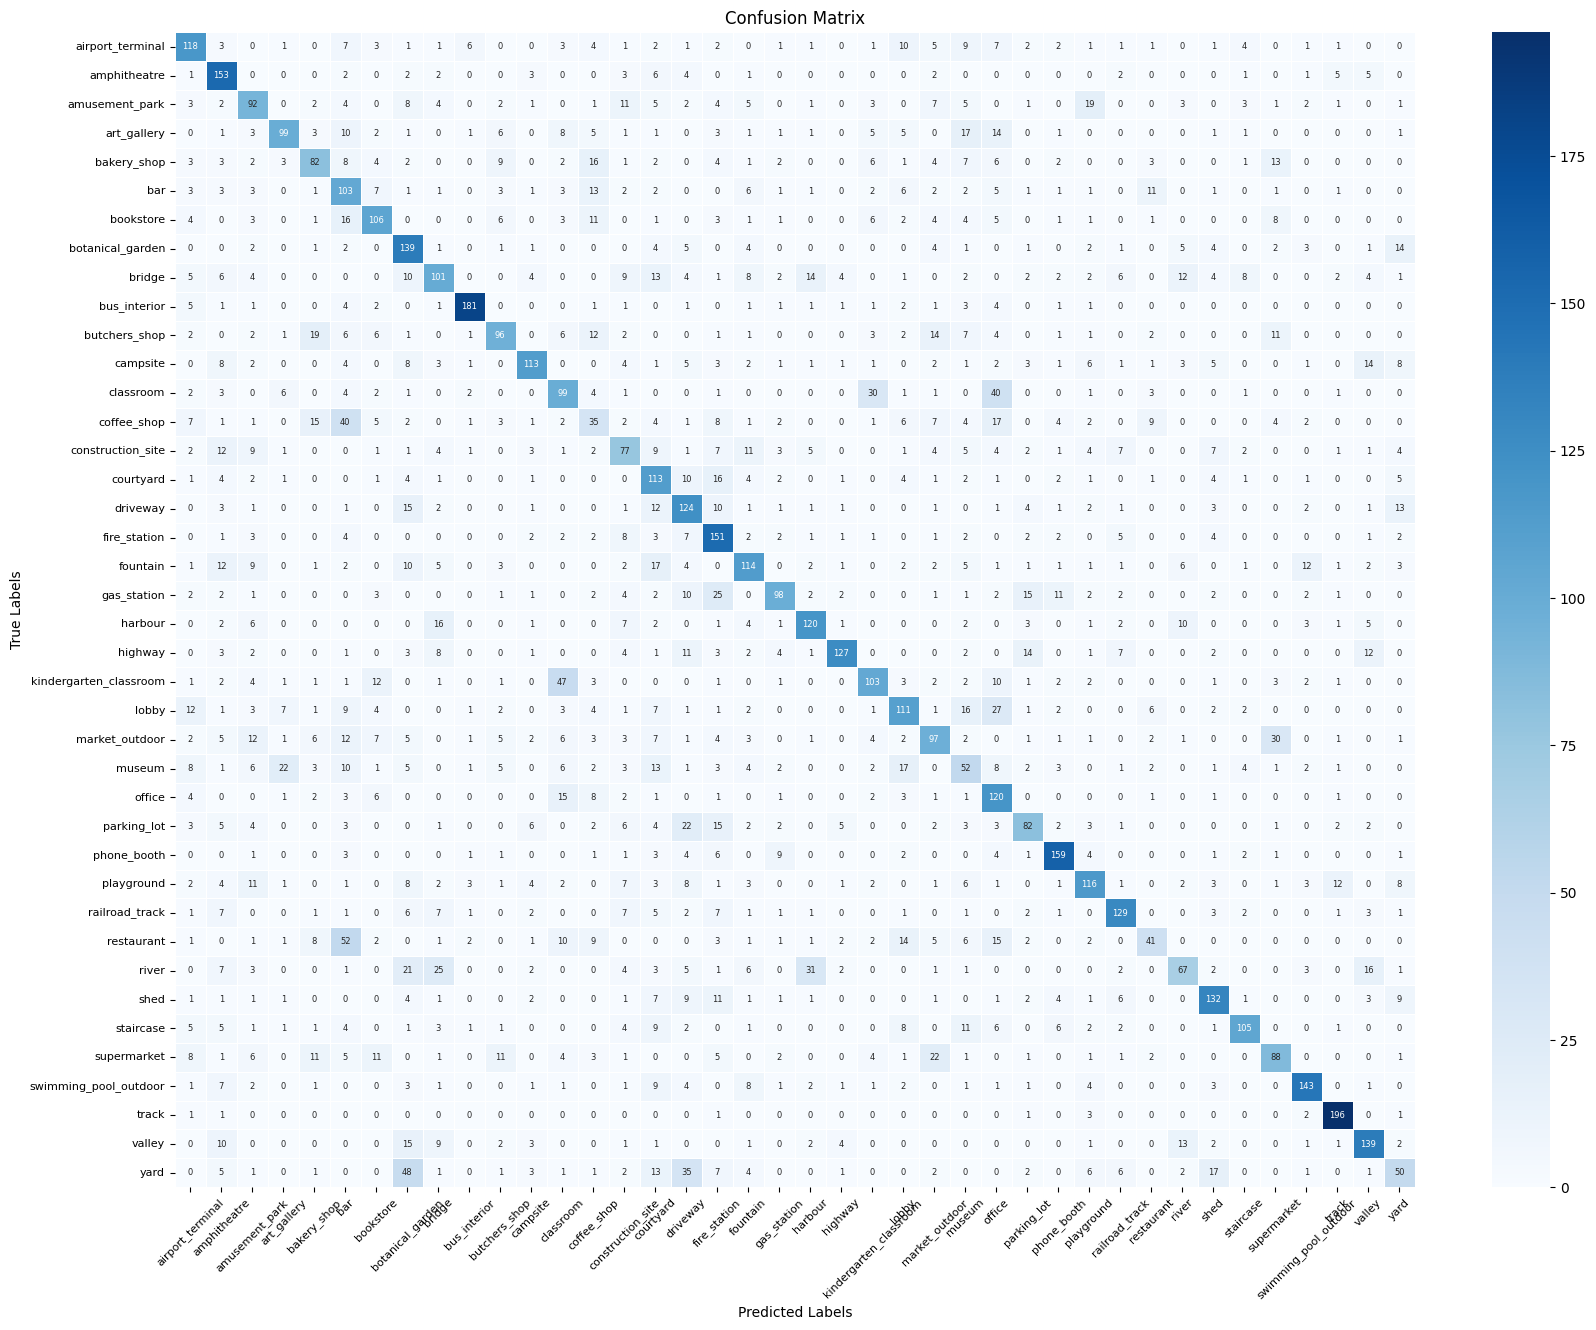

Model improved and saved with accuracy: 54.64%
Epoch 5/50:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

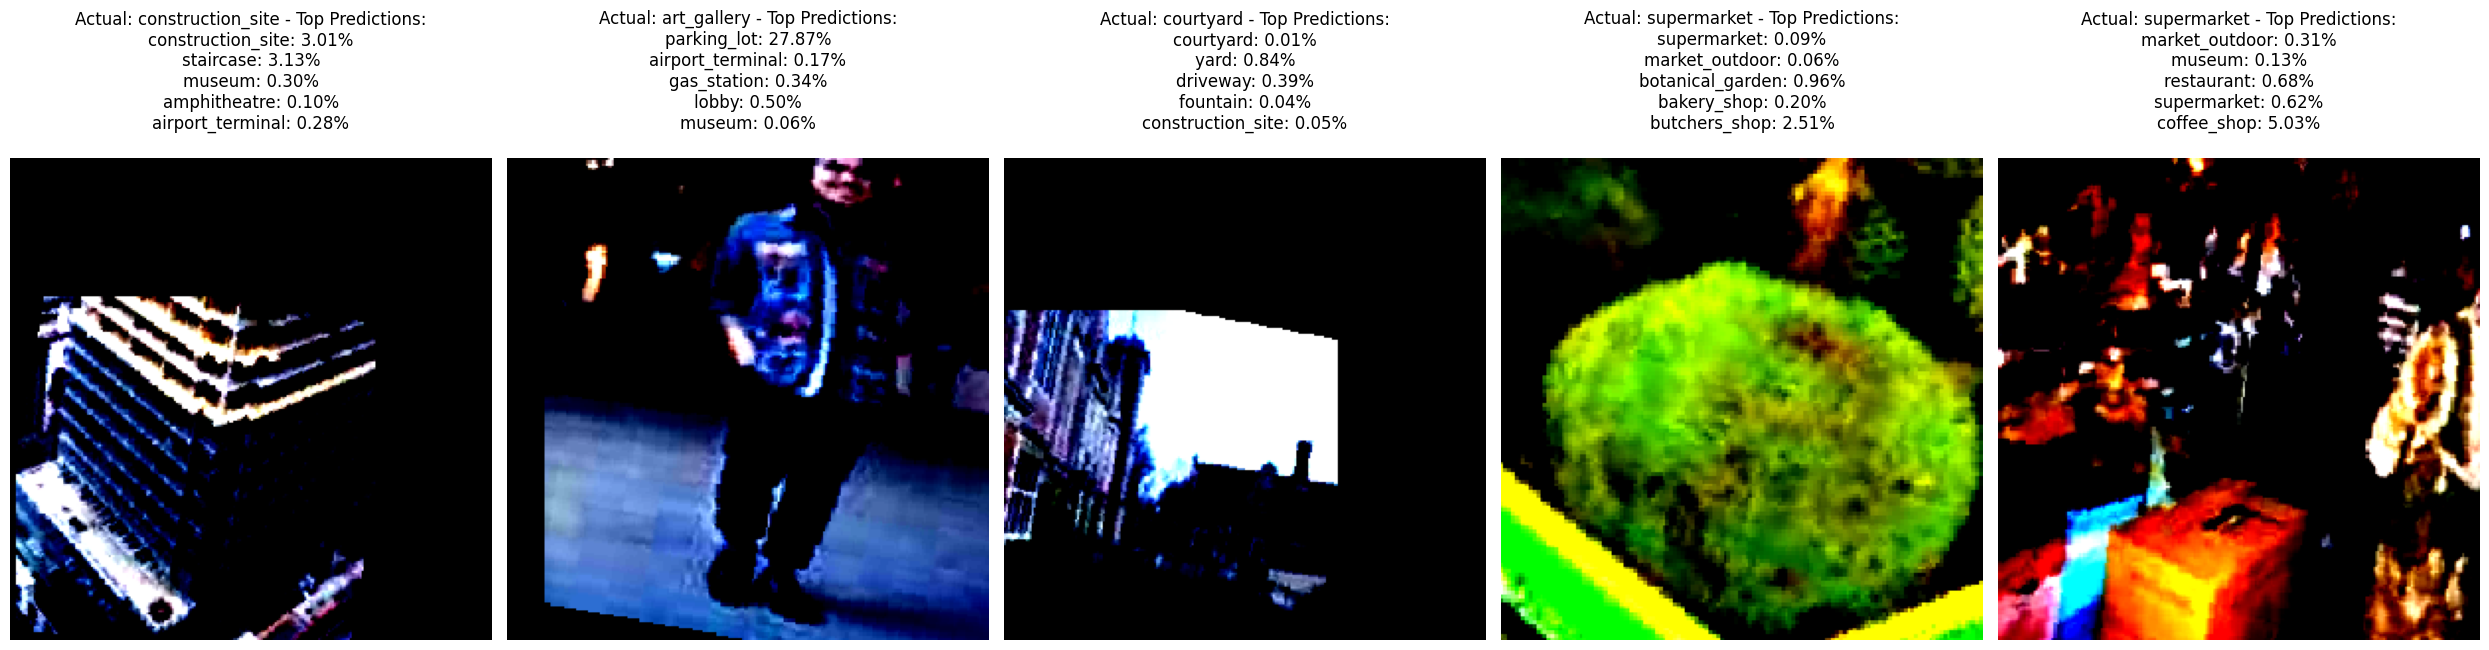

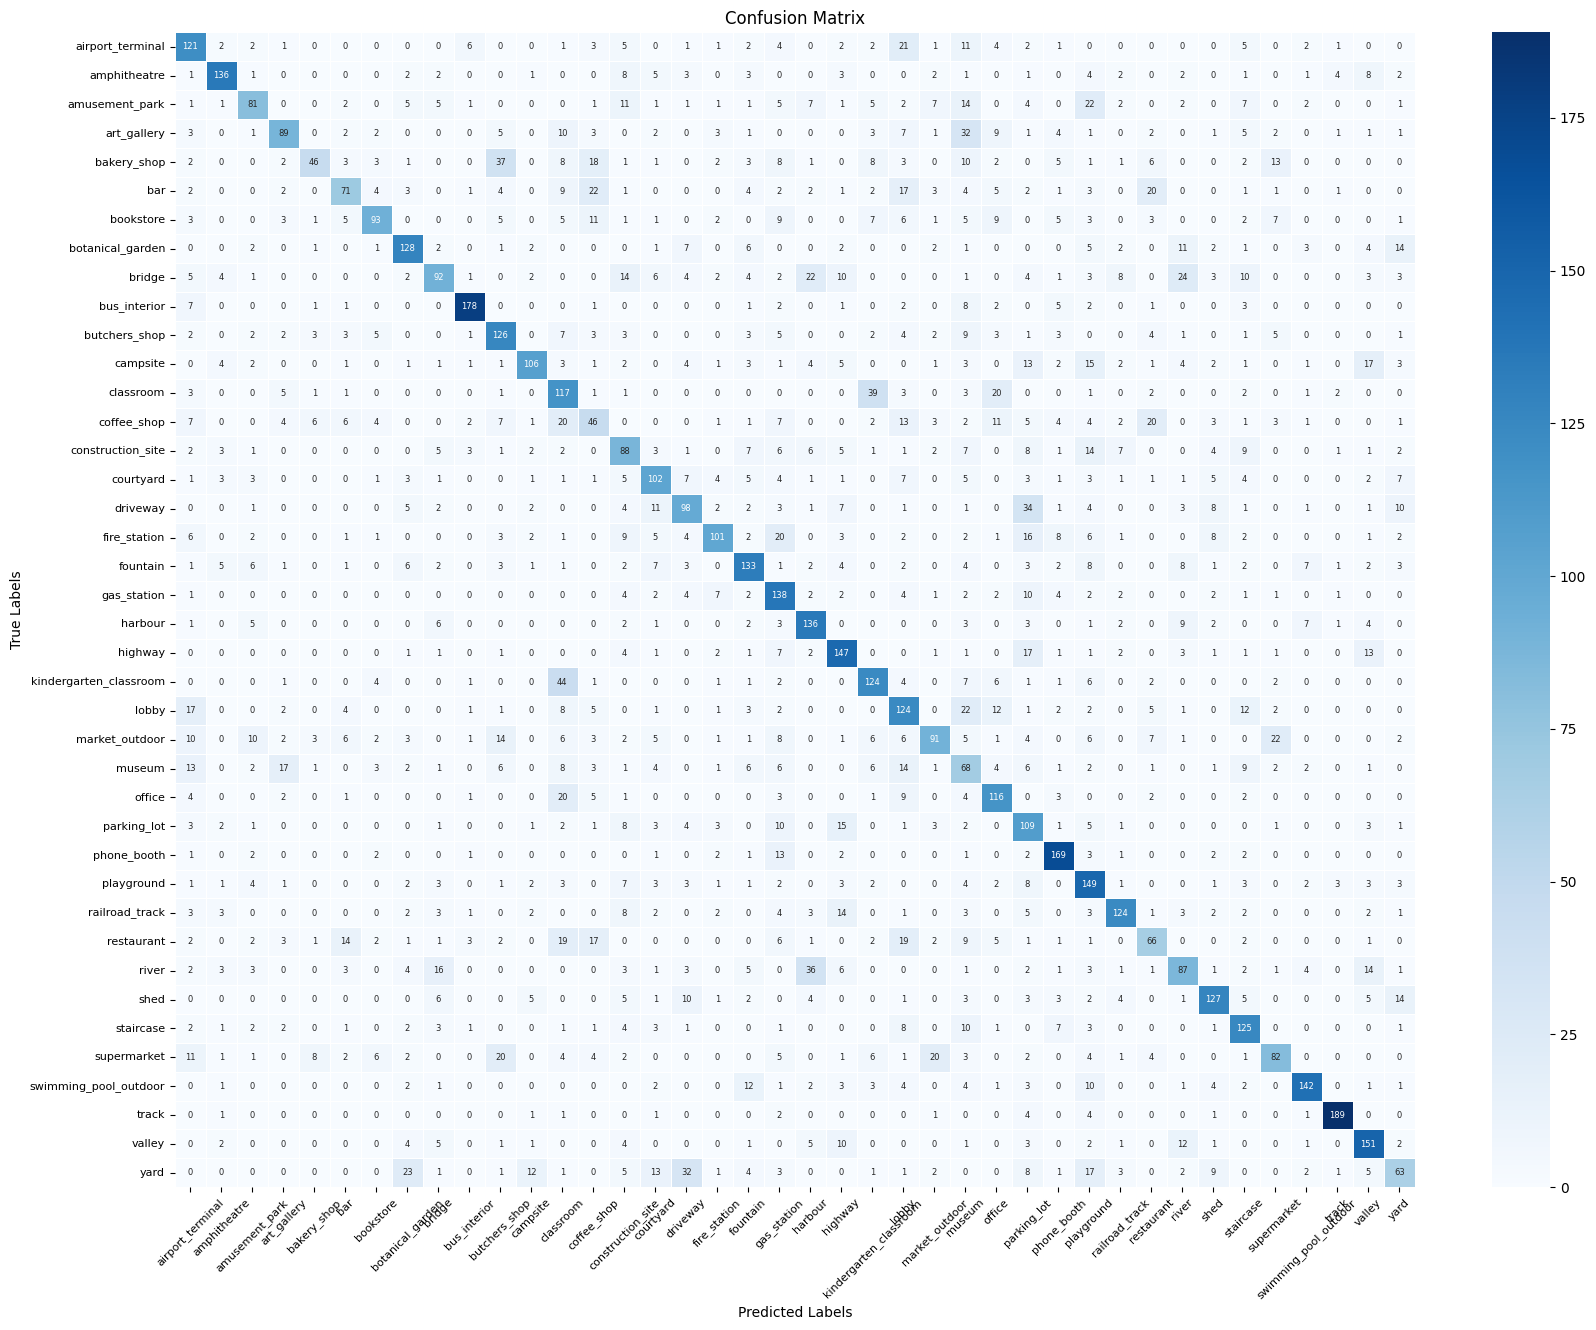

Model improved and saved with accuracy: 55.99%
Epoch 6/50:


  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# @title Metric evaluation



# Set up TensorBoard
writer = SummaryWriter('runs/scene_recognition_experaiment')
metric_log = {}
patience_counter = 0

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}:")
    metric_log[epoch] = {}
    ref = metric_log[epoch]

    # Run Training and validation loops and log all the data.
    ref["train_loss"] = train_epoch(model, device, train_loader,
                                    criterion, optimizer)
    val_metric = validate(model, device, val_loader, criterion, class_names)

    ref["val_loss"] = val_metric["loss"]
    ref["val_1"] = val_metric["accuracy_top1"]
    ref["val_5"] = val_metric["accuracy_top5"]
    ref["val_f1"] = val_metric["f1_score"]
    ref["val_mAP"] = val_metric["mAP"]
    val_true_labels = val_metric["true_labels"]
    val_pred_labels = val_metric["predicted_labels"]

    # Log metrics to TensorBoard
    writer.add_scalar('Training Loss', ref["train_loss"], epoch)
    writer.add_scalar('Validation Loss', ref["val_loss"], epoch)
    writer.add_scalar('Validation Top-1 Accuracy', ref["val_1"], epoch)
    writer.add_scalar('Validation Top-5 Accuracy', ref["val_5"], epoch)
    writer.add_scalar('Validation F1 Score', ref["val_f1"], epoch)
    writer.add_scalar('Validation mAP', ref["val_mAP"], epoch)

    # Visualize feature maps for validation after every 10 epoch
    if (epoch + 1) % 2 == 0 or epoch == 0:
        images, _ = next(iter(train_loader))
        print(f"Visualizing Feature Maps after Epoch {epoch + 1}")
        print('Visual features after 1st layer : \n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=0)
        print('Visual features after 3rd layer :\n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=2)
        print('Visual features after 4th layer :\n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=3)
        print('Visual features after 5th layer :\n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=4)
        print('Visual features after 7th layer :\n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=6)
        print('Visual features after final layer :\n\n')
        visualize_feature_maps(model, images[0].unsqueeze(0),
                               selected_layer_index=7)

    # Check for improvement
    if val_metric['loss'] < best_val_loss:
        best_val_loss = val_metric['loss']
        patience_counter = 0
        torch.save(model.state_dict(), '/content/best_model.pth')
        # Generate confusion matrix
        cm = confusion_matrix(val_metric['true_labels'],
                              val_metric['predicted_labels'])
        plot_confusion_matrix(cm, class_names)
        print(f"Model improved and saved with accuracy: {ref['val_1']:.2f}%")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break

# Reload the best model state for testing metrics
model.load_state_dict(torch.load('/content/best_model.pth'))

# Calculate the test metrics
test_metric = validate(model, device, test_loader, criterion, class_names)
test_loss = test_metric["loss"]
test_acc1 = test_metric["accuracy_top1"]
test_acc5 = test_metric["accuracy_top5"]
test_f1 = test_metric["f1_score"]
test_map = test_metric["mAP"]
test_cm = confusion_matrix(test_metric["true_labels"],
                           test_metric["predicted_labels"])
plot_confusion_matrix(test_cm, class_names)
display_top_predictions(model, device, test_loader, class_names)

# Log test metrics to TensorBoard
writer.add_scalar('Test Loss', test_loss, NUM_EPOCHS)
writer.add_scalar('Test Top-1 Accuracy', test_acc1, NUM_EPOCHS)
writer.add_scalar('Test Top-5 Accuracy', test_acc5, NUM_EPOCHS)
writer.add_scalar('Test F1 Score', test_f1, NUM_EPOCHS)
writer.add_scalar('Test mAP', test_map, NUM_EPOCHS)


# Close TensorBoard writer
writer.close()


In [ ]:
# @title Final Metrics Printout

print(f"""
   |-----------------HYPERPARAMETERS------------------|
   |                                                  |
   |      Number of Epochs: {NUM_EPOCHS:<25} |
   |         Learning Rate: {CL_LEARNING_RATE:<25} |
   |          Weight Decay: {WEIGHT_DECAY:<25} |
   |                                                  |
   |----------------DATASET PARAMETERS----------------|
   |                                                  |
   |   Training Batch Size: {TRAIN_BATCH_SIZE:<25} |
   | Validation Batch Size: {VALIDATION_BATCH_SIZE:<25} |
   |      Validation Split: {VALIDATION_SPLIT:<25} |
   |                                                  |
   |-------------------TEST METRICS-------------------|
   |                                                  |
   |             Test Loss: {test_loss:<25.4f} |
   |        Top 1 Accuracy: {test_acc1:<25.2f} |
   |        Top 5 Accuracy: {test_acc5:<25.2f} |
   |              F1 Score: {test_f1:<25.4f} |
   |                   mAP: {test_map:<25.4f} |
   |                                                  |
   |--------------------------------------------------|
""")

print("|-------| Training |Validation|-------|-------|----------|----------|")
print("| Epoch |   Loss   |   Loss   | Top 1 | Top 5 | F1 Score |   mAP    |")
print("|-------|----------|----------|-------|-------|----------|----------|")
for epoch in metric_log:
    p = metric_log[epoch]
    print(f"""|   {epoch + 1:<4}|  {p['train_loss']:<8.4f}|  {p['val_loss']:<8.4f}| {p['val_1']:<6.2f}| {p['val_5']:<6.2f}|  {p['val_f1']:<8.4f}|  {p['val_mAP']:<8.4f}|""")


In [ ]:
# Display tensorboard logs
%tensorboard --logdir runs